# Investigating factors leading to car crashes. 

Almost all of us drive every day. And we all face the danger of a car accident. Every day make a decision - should I drive to the destination via a highway or using local roads? Should I drive my child to school and let the school bus pick him/her up? Should I buy a sedan, SUV or coupe? Those decisions not only impact our convenience, but also our safety. 

The goal of this project is to investigate the factors which led to a car accident, including those, impacting the severity of injuries during the impact, as well as create a model to predict car crashes.
The project could be used by insurance agencies, car dealers, or just by people who are looking for a new, safer, car.

The dataset contains details about 101480  police-reported car accidents that happened in the US, including information about the vehicle, GPS coordinates,  road conditions, weather, information about the car, driver, severity of injury received by passengers. 

These crash reports are chosen from 60 selected areas across the United States that reflect the geography, population, miles driven, and crashes in the United States.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
# setup seaborn
sns.set()
sns.set_style("whitegrid")
sns.set_context("notebook")

## Data Reading and cleaning

In [3]:
accidents2016 = pd.read_csv("data/CRSS2016CSV/ACCIDENT.csv")
accidents2017 = pd.read_csv("data/CRSS2017CSV/ACCIDENT.csv")
accidents = accidents2016.append(accidents2017, sort=False)

In [4]:
vehicles2016 = pd.read_csv("data/CRSS2016CSV/VEHICLE.csv", low_memory=False)
vehicles2017 = pd.read_csv("data/CRSS2017CSV/VEHICLE.csv", low_memory=False)
vehicles = vehicles2016.append(vehicles2017, sort=False)

In [5]:
persons2016 = pd.read_csv("data/CRSS2016CSV/PERSON.csv")
persons2017 = pd.read_csv("data/CRSS2017CSV/PERSON.csv")
persons = persons2016.append(persons2017, sort=False)

In [6]:
vindecode2016 = pd.read_csv("data/CRSS2016CSV/VINDECODE.csv", low_memory=False)
vindecode2017 = pd.read_csv("data/CRSS2017CSV/VINDECODE.csv", low_memory=False)
vindecode = vindecode2016.append(vindecode2017, sort=False)

In [7]:
distract2016 = pd.read_csv("data/CRSS2016CSV/distract.csv")
distract2017 = pd.read_csv("data/CRSS2017CSV/distract.csv")
distract = distract2016.append(distract2017, sort=False)

In [8]:
overlaping_columns = ['CASENUM', 'REGION', 'PSU', 'PJ', 'PSU_VAR', 'URBANICITY', 'STRATUM', 'VE_FORMS',
                      'MONTH', 'HOUR', 'MINUTE', 'HARM_EV', 'MAN_COLL', 'SCH_BUS', 'PSUSTRAT',
                      'WEIGHT']
df = accidents.merge(persons,  on=overlaping_columns, suffixes=(False, False))

In [9]:
overlaping_columns = ['CASENUM', 'VEH_NO', 'REGION', 'PSU', 'PJ', 'PSU_VAR', 'URBANICITY', 'STRATUM', 'VE_FORMS',
       'MONTH', 'HOUR', 'MINUTE', 'HARM_EV', 'MAN_COLL', 'PSUSTRAT', 'WEIGHT',
       'MAKE', 'BODY_TYP', 'MOD_YEAR', 'MAK_MOD', 'TOW_VEH', 'SPEC_USE',
       'EMER_USE', 'ROLLOVER', 'IMPACT1', 'FIRE_EXP']
df = df.merge(vehicles, on= overlaping_columns,suffixes=(False, False))

In [10]:
overlaping_columns = ["CASENUM", "VEH_NO", "VIN"]
df = df.merge(vindecode, on=overlaping_columns, suffixes=(False, False), how="inner")

In [11]:
overlaping_columns = ["CASENUM", "VEH_NO", 'PSU', 'PJ', 'STRATUM', 'URBANICITY', 'REGION', 'PSUSTRAT', 'PSU_VAR',
       'WEIGHT']
df = df.merge(distract, on=overlaping_columns, suffixes=(False, False), how="inner")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221860 entries, 0 to 221859
Columns: 259 entries, CASENUM to MDRDSTRD
dtypes: float64(32), int64(142), object(85)
memory usage: 440.1+ MB


In [13]:
def plot_normalized(
    data,
    column_name,
    aggregate_column="MAX_VSEV",
    sort_by="Serious or fatal",
    normalize=True,
):

    props = (
        data.groupby(column_name)[aggregate_column]
        .value_counts(normalize=normalize)
        .unstack()
    )

    props["Serious or fatal"] = (
        15 * props["4 - Fatal"]
        + 5 * props["3 - Serious Injury"]
        + 1 * props["2 - Minor Injury"]
        - 3 * props["0 - No Apparent Injury"]
    )
    
    if sort_by != "":
        props.sort_values(by=sort_by, ascending=False, inplace=True)
    props.drop(columns=["Serious or fatal"], inplace=True)

    g = props.plot(
        kind="bar",
        stacked=True,
        colormap=ListedColormap(sns.color_palette("RdYlGn_r", 5)),
        figsize=(15, 5),
    )
    plt.legend(title="Injury Severity")
    return g

In [14]:
from scipy import stats

def get_chi2_p(data, filters, column_name, aggregate_column="MAX_VSEV"):

    props = data.groupby(column_name)[aggregate_column].value_counts().unstack()
    
    chi2, p, dof, ex = stats.chi2_contingency(props[props.index.isin(filters)])
    
    return p

In [25]:
threshold = 300
vc = df["BODYSTYL_T"].value_counts()
vals_to_remove = vc[vc <= threshold].index.values
df["BODYSTYL_T"].loc[df["BODYSTYL_T"].isin(vals_to_remove)] = np.nan

C:\Users\Aleks\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
severety = {
    0: "0 - No Apparent Injury",
    1: "1 - Possible Injury",
    2: "2 - Minor Injury",
    3: "3 - Serious Injury",
    4: "4 - Fatal",
    5: np.nan,
    6: np.nan,
    8: np.nan,
    9: np.nan,
}
df.MAX_SEV = df.MAX_SEV.replace(severety)
df.MAX_VSEV = df.MAX_VSEV.replace(severety)
df.INJ_SEV = df.INJ_SEV.replace(severety)

In [16]:
MDRDSTRD_dict = {
    0: "Not Distracted",
    1: "Looked But Did Not See",
    3: "By Other Occupants",
    4: "By a Moving Object In Vehicle",
    5: "Cellular Phone",
    6: "Cellular Phone",
    7: "While Adjusting Controls",
    9: "While Adjusting Controls",
    10: "While Using Or Reaching For Device/Object Brought into Vehicle",
    12: "Distracted By Outside Person, Object Or Event",
    13: "Eating Or Drinking",
    14: "Smoking Related",
    15: "Cellular Phone",
    16: np.nan,
    17: "Inattention",
    18: "Careless",
    19: "Inattention",
    92: "Inattention",
    93: "Inattention",
    96: np.nan,
    97: "Lost In Thought/Day Dreaming",
    98: np.nan,
    99: np.nan,
}
df.MDRDSTRD = df.MDRDSTRD.replace(MDRDSTRD_dict)

In [17]:
makers_dict = {
    2: "Jeep",
    6: "Chrysler",
    7: "Dodge",
    12: "Ford",
    18: "Buick",
    20: "Chevrolet",
    22: "Pontiac",
    23: "GMC",
    30: "Volkswagen",
    34: "BMW",
    35: "Nissan",
    37: "Honda",
    41: "Mazda",
    42: "Mercedes-Benz",
    48: "Subaru",
    49: "Toyota",
    55: "Hyundai",
    59: "Lexus",
    63: "Kia",
    19: "Cadillac",
    54: "Acura",
    52: "Mitsubishi",
    82: "Freightliner/White",
    58: "Infiniti",
    72: "Harley-Davidson",
    14: "Mercury",
    24: "Saturn",
    51: "Volvo",
    13: "Lincoln",
    98: "Other Make",
    53: "Suzuki",
    84: "International Harvester/Navistar",
    99: np.nan,
}

df.MAKE = df.MAKE.replace(makers_dict)

major_manufactors = (df.MAKE.value_counts(normalize=True)>0.006).reset_index()
major_manufactors = major_manufactors[major_manufactors['MAKE'] == True]['index'].tolist()

In [18]:
SEAT_POS_dict = {
    11: "Front Seat – Driver’s Side)",
    12: "Front Seat – Middle",
    13: "Front Seat – Right Side",
    21: "Second Seat – Left Side",
    22: "Second Seat – Middle",
    23: "Second Seat – Right Side",
    31: "Third Seat – Left Side",
    32: "Third Seat – Middle",
    33: "Third Seat – Right Side",
    98: np.nan,
    51: np.nan,
    18: np.nan,
    99: np.nan,
    52: np.nan,
    28: np.nan,
    50: np.nan,
    19: np.nan,
    53: np.nan,
    38: np.nan,
    29: np.nan,
    55: np.nan,
    41: np.nan,
    39: np.nan,
    49: np.nan,
    42: np.nan,
    43: np.nan,
    54: np.nan,
}
df.SEAT_POS = df.SEAT_POS.replace(SEAT_POS_dict)

In [19]:
REST_USE_dict = {
    0: np.nan,
    1: "Belt Used",
    2: "Belt Used",
    3: "Belt Used",
    4: "Child Restraint Type Unknown",
    5: "Helmet",
    7: "None Used",
    8: "Belt Used",
    10: "Child Restraint System – Forward Facing",
    11: "Child Restraint System – Rear Facing",
    12: "Booster Seat",
    16: "Helmet",
    17: "No Helmet",
    19: "Helmet",
    20: "None Used",
    29: np.nan,
    96: np.nan,
    97: np.nan,
    98: np.nan,
    99: np.nan,
}
df.REST_USE = df.REST_USE.replace(REST_USE_dict)

In [20]:
P_CRASH3_dict = {
    0: "No Driver Present/Unknown if Driver Present",
    1: "No Avoidance Maneuver",
    5: "Releasing Brakes",
    6: "Steering Left",
    7: "Steering Right",
    8: "Braking And Steering Left",
    9: "Braking And Steering Right",
    10: "Accelerated",
    11: "Accelerating And Steering Left",
    12: "Accelerating And Steering Right",
    15: "Braking and Unknown Steering Direction",
    16: "Braking",
    98: np.nan,
    99: np.nan,
}
df.P_CRASH3 = df.P_CRASH3.replace(P_CRASH3_dict)

In [21]:
SPEEDREL_dict = {
    0: '0 - No',
    2: '3 - Yes, Racing',
    3: '2 - Yes, Exceeded Speed Limit',
    4: '1 - Yes, Too Fast for Conditions',
    5: np.nan,
    8: np.nan,
    9: np.nan,
}
df.SPEEDREL = df.SPEEDREL.replace(SPEEDREL_dict)

In [22]:
df.MOD_YEAR.replace([9998, 9999], np.nan, inplace=True)

## Visualization and statistic analysis 

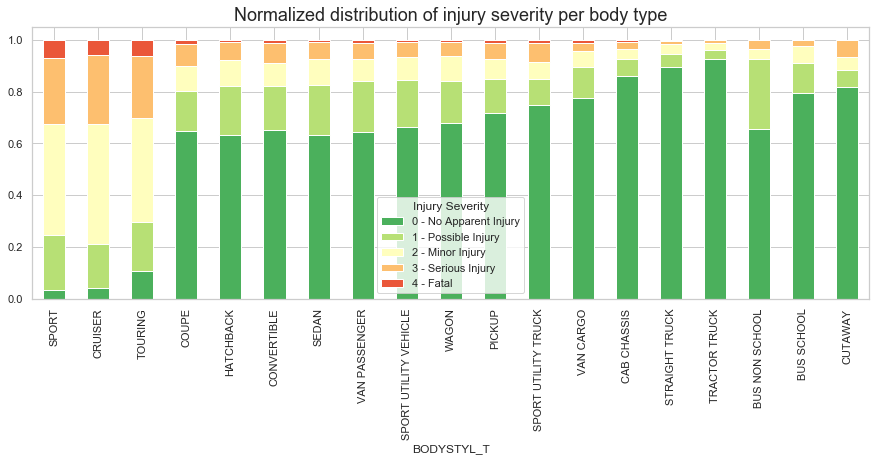

In [26]:
plot_normalized(df, "BODYSTYL_T")
plt.title(
    "Normalized distribution of injury severity per body type",
    size=18,
)
plt.show()

This plot shows the normalized distribution of injury severity per body type for accidents happened in 2016-2017 years. 
Different vehicle body types strongly impact the severity of the injury if a crash happened. 
For motorcycles, if a crash happened, there is almost no chance not to receive any injury, while for any car your chances are about 65-85%. 
The safest are buses, followed by trucks. Weight of the vehicle matters a lot!
Coupes, as well as convertibles, shows a large fatality rate.
While the most popular car types - sedans and SUV shows visually similar distributions, Chi-square test of independence shows that distribution of injury severity for sedans and SUV are independent (with p-value 1.77e-28) - in other words, body type indeed affects injury severity:


In [65]:
get_chi2_p(df, ["SEDAN", "SPORT UTILITY VEHICLE"], "BODYSTYL_T")

1.7742313124813528e-28

In [66]:
get_chi2_p(df, ["SEDAN", "COUPE"], "BODYSTYL_T")

4.885270843972007e-27

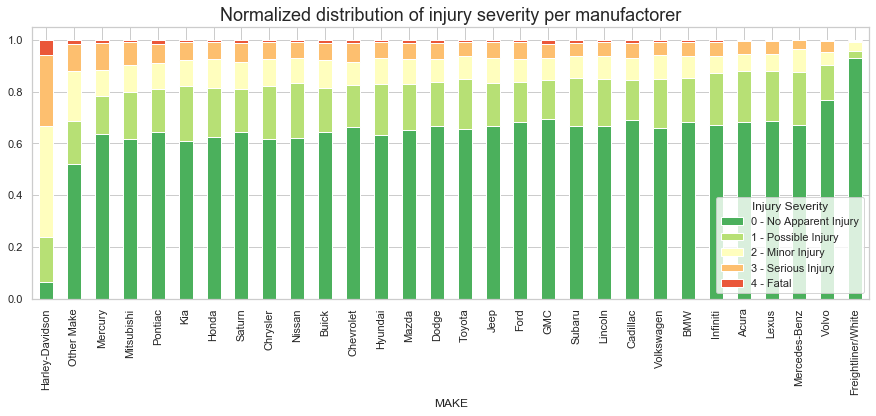

In [35]:
plot_normalized(df[df.MAKE.isin(major_manufactors)], "MAKE")
plt.title(
    "Normalized distribution of injury severity per manufactorer",
    size=18,
)
plt.show()

Do your chances to get insured, if a crash happens, depend on the manufacturer of the car you are in? Well, this plot shows that it does. Apart from a truck maker, Volvo is by far the safest car, followed by Mercedes, Lexus, Acura. Infinity and BMV. Mercury, Mitsubishi, Pontiac, and Kia among the least safe. 
Now we know that choosing a luxury car is not only about comfort but also about safety. This information could be used by car dealers to promote certain safer brands.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

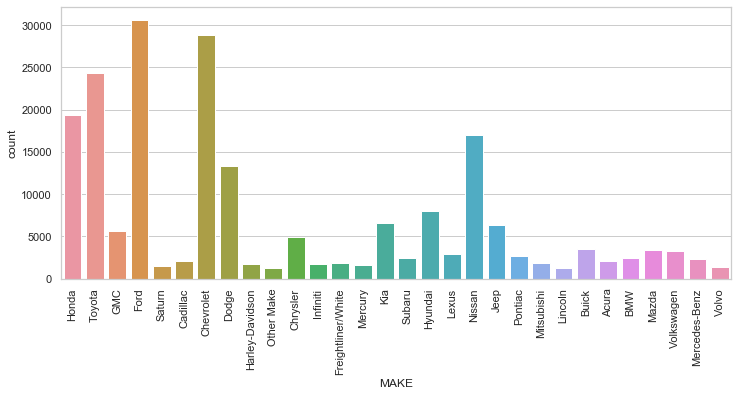

In [51]:
fig= plt.figure(figsize=(12,5))
sns.countplot(df[df.MAKE.isin(major_manufactors)].MAKE)
plt.xticks(rotation=90)

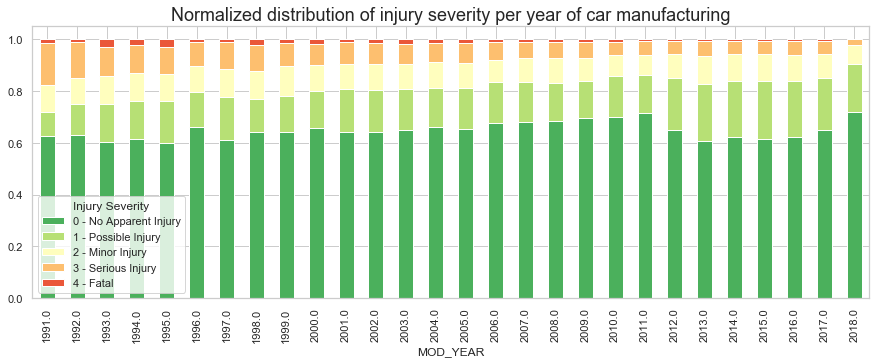

In [73]:
plot_normalized(df[(df.MOD_YEAR > 1990)], "MOD_YEAR", sort_by = "")
plt.title(
    "Normalized distribution of injury severity per year of car manufacturing",
    size=18,
)
plt.show()

From this plot, we can see those modern cars provide much better protection for its riders against severe and fatal insures. But something happened right after the 2010 year - the percentage of passengers with no or minor injures dropped, while protection against fatal and severe injuries keep improving. So the question of whether to upgrade the car is not only about convenience but also about safety

#### What about factors that lead to an accident?

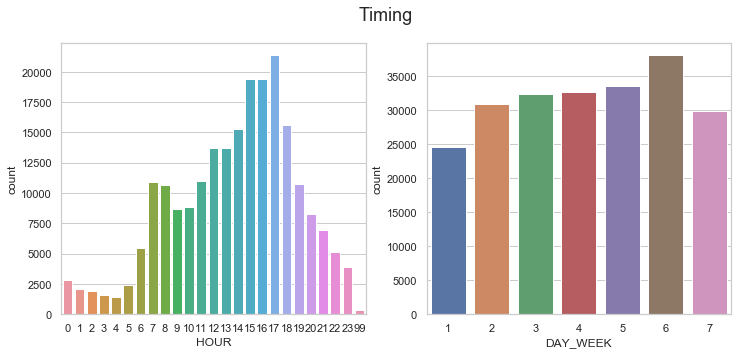

In [70]:
plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle("Timing", fontsize=18)
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(121)
sns.countplot(df.HOUR)

plt.subplot(122)
sns.countplot(df.DAY_WEEK)

plt.show()

It seems that the more tires the drivers are, the more accidents happened. Afterwork hours are more dangerous than during the morning rush, and the furthest we are from the beginning of the work week, the worse.

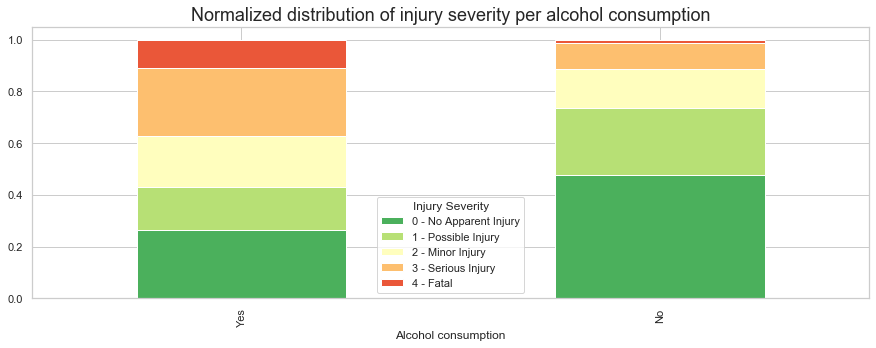

In [71]:
plot_normalized(df, "ALCHL_IM", "MAX_SEV")
plt.title(
    "Normalized distribution of injury severity per alcohol consumption",
    size=18,
)
plt.xlabel("Alcohol consumption")
plt.xticks([0, 1], ("Yes", "No"))
plt.show()

Crashes happened when on the drivers is under influence, are much more deadly than those without. 
This statistic can be used to persuade people not to drive under alcohol influence. One thing is to know that it is dangerous, and others - know just how much dangerous it is.


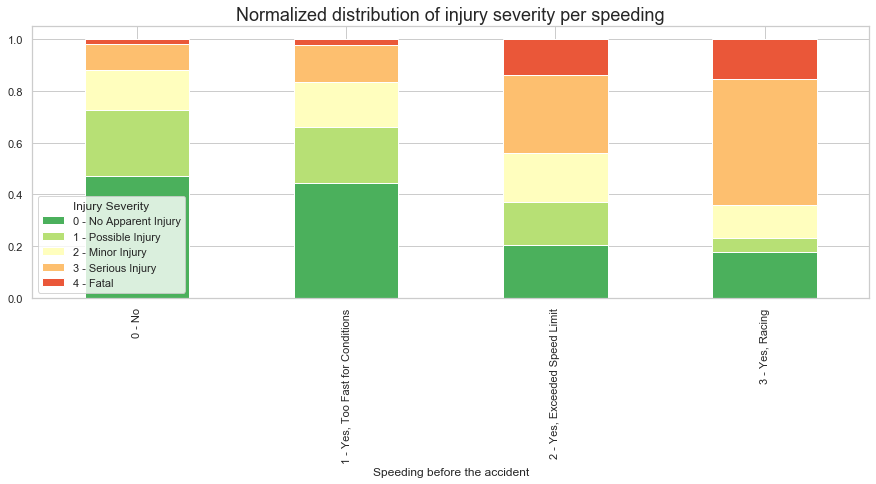

In [60]:
plot_normalized(df, "SPEEDREL", "MAX_SEV", sort_by="")
plt.title("Normalized distribution of injury severity per speeding", size=18)
plt.xlabel('Speeding before the accident')
plt.show()

Same story with speeding. Chances to get killed or to kill someone during the crash when you’re speeding are $8$ times larger than when you don’t! 

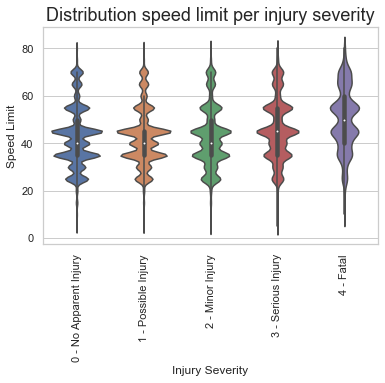

In [38]:
sns.violinplot(
    y="VSPD_LIM",
    x="MAX_SEV",
    order=[
        "0 - No Apparent Injury",
        "1 - Possible Injury",
        "2 - Minor Injury",
        "3 - Serious Injury",
        "4 - Fatal",
    ],
    data=df[(df["VSPD_LIM"] > 0) & (df["VSPD_LIM"] < 97)],
)

plt.xticks(rotation=90)
plt.title("Distribution speed limit per injury severity", size=18)
plt.ylabel("Speed Limit")
plt.xlabel("Injury Severity")
plt.show()

Accidents with severe injuries happen mostly on highways.  

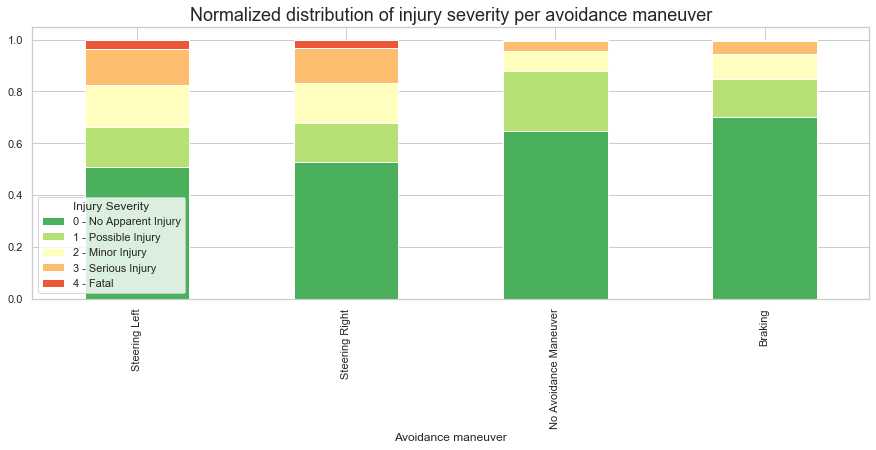

In [47]:
data = df[
    df.P_CRASH3.isin(
        ["No Avoidance Maneuver", "Steering Left", "Steering Right", "Braking"]
    )
]

plot_normalized(data, "P_CRASH3")
plt.title("Normalized distribution of injury severity per avoidance maneuver", size=18)
plt.xlabel('Avoidance maneuver')
plt.show()

If you found yourself in a pre-accident situation, remember, that accidents happened when driver was trying to maneuver by steering more dangerous than those when you do nothing or just brake.

The chi-squared test below shows that the is no significant difference between steering left or right, but there is a strong difference between braking and steering left (right).


In [75]:
get_chi2_p(df, ["Steering Right", "Steering Left"], "P_CRASH3")

0.4356781892724938

In [76]:
get_chi2_p(df, ["Braking", "Steering Left"], "P_CRASH3")

4.4512624856085415e-136

In [77]:
get_chi2_p(df, ["Braking", "No Avoidance Maneuver"], "P_CRASH3")

6.494696197788735e-67

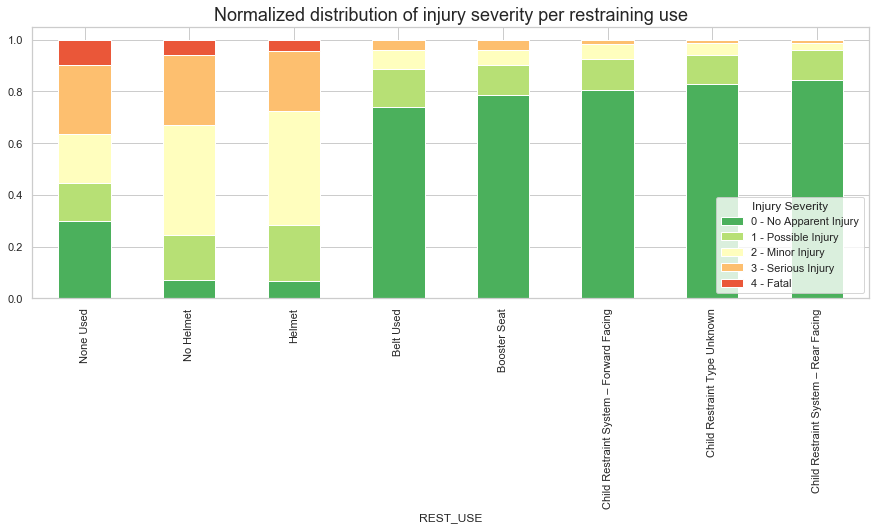

In [62]:
plot_normalized(
    df, column_name="REST_USE", aggregate_column="INJ_SEV", sort_by="4 - Fatal"
)
plt.title("Normalized distribution of injury severity per restraining use", size=18)
plt.show()

Remember that plots that show that motorcycles are unsafe? Well, driving inside the car without buckling up is even worse! In fact, your chances to get killed are $28$ times larger when you are not buckled up! I personally know people who drive without a belt, you can even buy a belt fasteners placeholder on ebay, which will stop your car from beeping in protest. Educating people about the importance of the seat belt is very important.
Also, we can see that a rear-facing child seat is safer than front-facing.


In [63]:
df.groupby("REST_USE")["INJ_SEV"].value_counts(normalize=True).unstack()

INJ_SEV,0 - No Apparent Injury,1 - Possible Injury,2 - Minor Injury,3 - Serious Injury,4 - Fatal
REST_USE,,,,,
Belt Used,0.738526,0.147503,0.072443,0.038085,0.003442
Booster Seat,0.784653,0.117574,0.058168,0.037129,0.002475
Child Restraint System – Forward Facing,0.804834,0.120839,0.055632,0.016416,0.002280
Child Restraint System – Rear Facing,0.845122,0.114634,0.025610,0.013415,0.001220
Child Restraint Type Unknown,0.828912,0.110610,0.046684,0.011671,0.002122
Helmet,0.066461,0.218856,0.440495,0.229985,0.044204
No Helmet,0.071170,0.174910,0.422195,0.270205,0.061520
None Used,0.298946,0.147399,0.190081,0.266978,0.096596


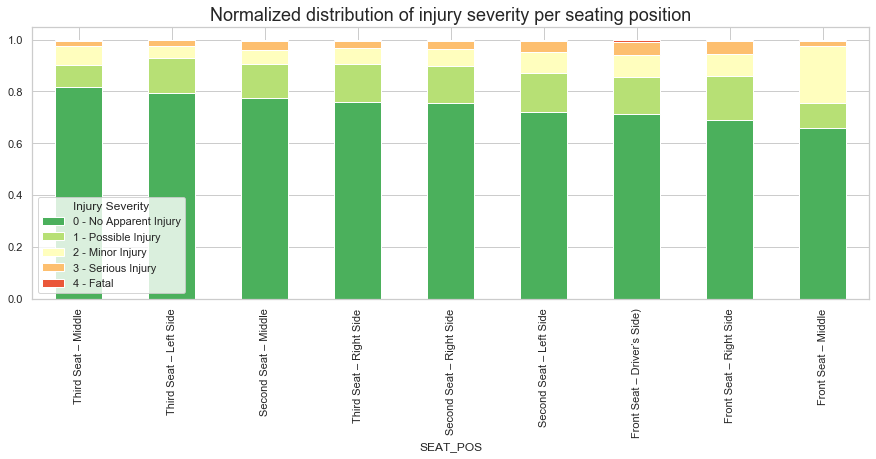

In [49]:
plot_normalized(df, column_name = "SEAT_POS", aggregate_column = 'INJ_SEV', sort_by = "0 - No Apparent Injury")
plt.title(
    "Normalized distribution of injury severity per seating position",
    size=18,
)
plt.show()

Front seats are more dangerous than the ones on the second or third row.


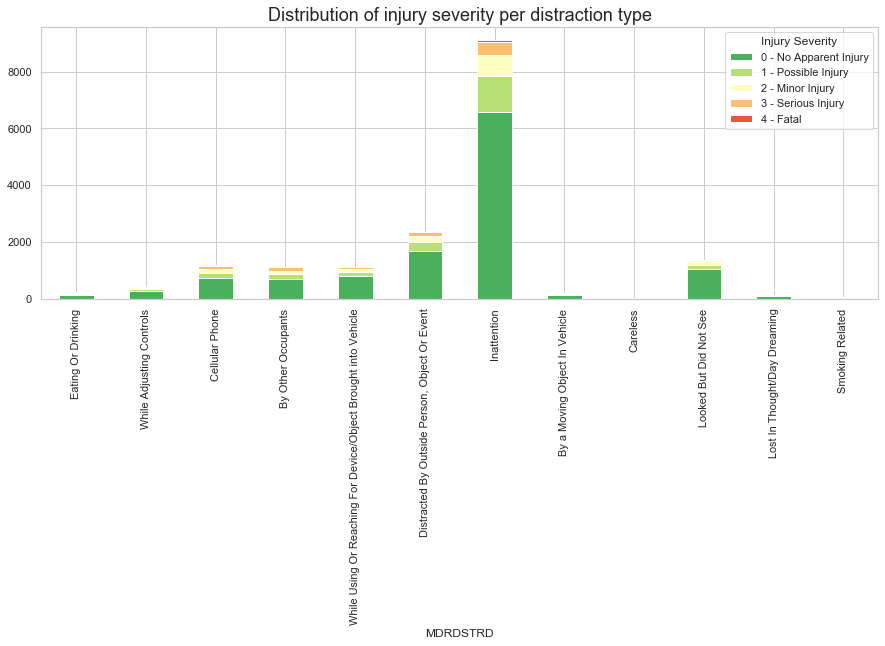

In [41]:
plot_normalized(df[df.MDRDSTRD != "Not Distracted"], "MDRDSTRD", normalize=False)
plt.title("Distribution of injury severity per distraction type", size=18)
plt.show()

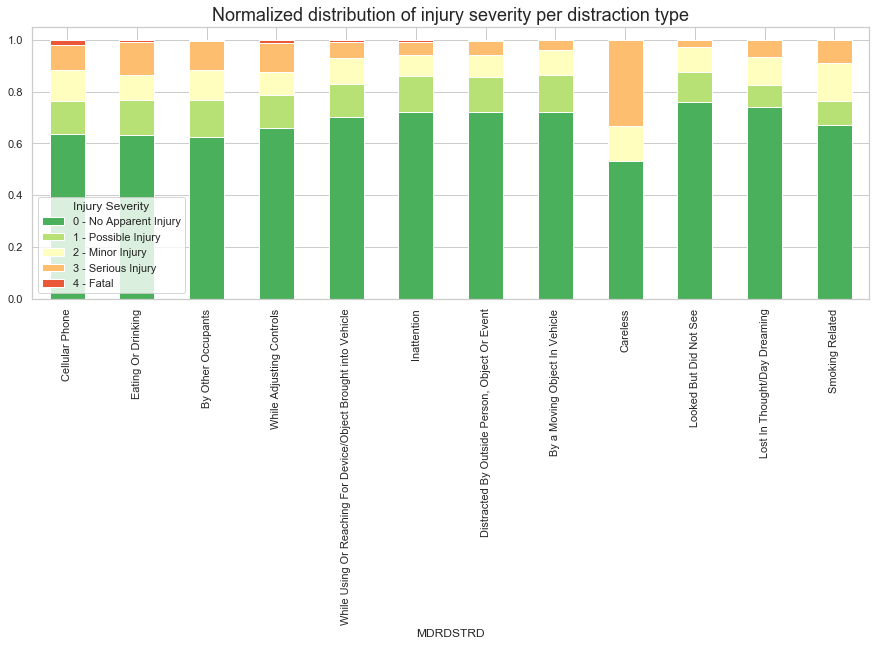

In [42]:
plot_normalized(df[df.MDRDSTRD != "Not Distracted"], "MDRDSTRD", normalize=True)
plt.title("Normalized distribution of injury severity per distraction type", size=18)
plt.show()